In [1]:
import yfinance as yf
import pandas as pd
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import scipy.stats as stats
import pylab

In [2]:
# Define the stock symbol (AAPL for Apple)
stock_symbol = "AAPL"

df = yf.download(stock_symbol, start="2021-01-01", end="2022-08-10")[["Close"]]

# Print the fetched data
df.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2021-01-04,129.410004
2021-01-05,131.009995
2021-01-06,126.599998
2021-01-07,130.919998
2021-01-08,132.050003


In [3]:
df.isna().sum()

Close    0
dtype: int64

<AxesSubplot:xlabel='Date'>

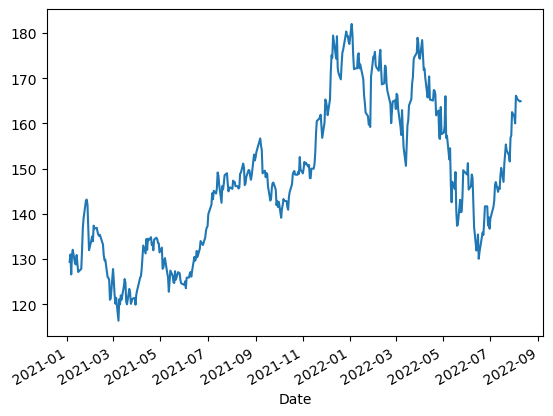

In [4]:
df["Close"].plot(kind="line")

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Close"])
result

(-1.6784518870010088,
 0.4422475060243082,
 0,
 402,
 {'1%': -3.446722009322339,
  '5%': -2.868756617175256,
  '10%': -2.570614247667137},
 1851.215533109279)

In [6]:
adfuller(df["Close"].diff().dropna())

(-20.11594269262834,
 0.0,
 0,
 401,
 {'1%': -3.4467631030732506,
  '5%': -2.868774682311516,
  '10%': -2.570623877774392},
 1853.5663903400257)

<AxesSubplot:xlabel='Date'>

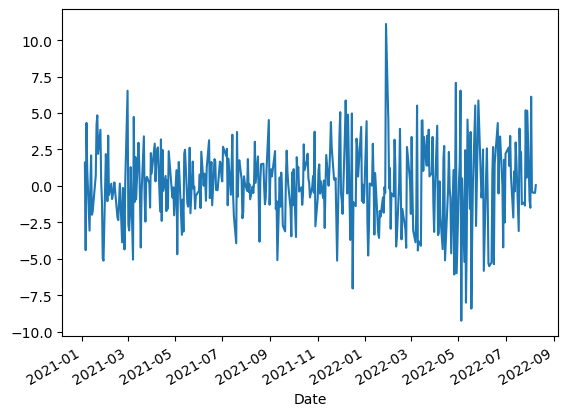

In [7]:
df_stat = df["Close"].diff().dropna()
df_stat.plot(kind="line")

In [8]:
df_stat.head(7)

Date
2021-01-05    1.599991
2021-01-06   -4.409996
2021-01-07    4.320000
2021-01-08    1.130005
2021-01-11   -3.070007
2021-01-12   -0.179993
2021-01-13    2.089996
Name: Close, dtype: float64

In [9]:
generator = TimeseriesGenerator(df_stat,df_stat,length=7,batch_size=1)

In [10]:
generator[0]

(array([[ 1.59999084, -4.40999603,  4.31999969,  1.13000488, -3.07000732,
         -0.17999268,  2.08999634]]),
 array([-1.97999573]))

In [11]:
data_columns = ['day1', 'day2', 'day3', 'day4', 'day5', 'day6','day7']
target_column = 'Target'
data_rows = []
target_rows = []

# Iterate through the generator
for batch_data, batch_targets in generator:
    data_rows.append(list(batch_data[0]))
    target_rows.append(batch_targets[0])

# Create the new DataFrame
df1 = pd.DataFrame(data_rows, columns=data_columns)
df1[target_column] = target_rows


In [12]:
df1.head()

,day1,day2,day3,day4,day5,day6,day7,Target
0,1.599991,-4.409996,4.320000,1.130005,-3.070007,-0.179993,2.089996,-1.979996
1,-4.409996,4.320000,1.130005,-3.070007,-0.179993,2.089996,-1.979996,-1.770004
2,4.320000,1.130005,-3.070007,-0.179993,2.089996,-1.979996,-1.770004,0.690002
3,1.130005,-3.070007,-0.179993,2.089996,-1.979996,-1.770004,0.690002,4.199997
4,-3.070007,-0.179993,2.089996,-1.979996,-1.770004,0.690002,4.199997,4.839996


In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit

In [14]:
x_train,x_test,y_train,y_test = train_test_split(df1.drop("Target",axis=1).values,df1.Target,test_size=0.25,shuffle=False)

In [15]:
print(x_train.shape)
print(x_test.shape)

(296, 7)
(99, 7)


In [16]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBRegressor(n_jobs=-1)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=5, verbose=2,n_jobs=-1)


In [17]:
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_byt

In [18]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 1.0}
-1.883507321732445


In [73]:
x_test = x_train[-1].reshape(1,-1)
pred_x =  []
for i in range(len(y_test)):
    pred_ = grid_search.predict(x_test[:,-7:])[0]
    pred_x.append(pred_)
    x_test = np.append(x_test,np.array([grid_search.predict(x_test[:,-7:])]).reshape(1,1)).reshape(1,-1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
from sklearn.metrics import mean_absolute_error as mae , mean_absolute_percentage_error as mape

In [85]:
final_ = pred_x.copy()
final_

[0.14915344,
 -0.09244838,
 -0.035980385,
 0.024691889,
 0.47893557,
 0.44366622,
 0.4022966,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.22008295,
 0.22008295,
 0.22008295,
 0.16827446,
 0.16827446,
 0.16827446,
 0.220082

In [86]:
for i in range(len(final_)):
    final_[i] = final_[i] + df["Close"][-100:][i]

In [89]:
print("mean absolute error  :  " , mae(df["Close"][-99:],final_))
print("mean absolute percentage error  :  " , mape(df["Close"][-99:],final_))

mean absolute error  :   2.7160698258402673
mean absolute percentage error  :   0.017878264512914886
